In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Packages and imports

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import random
import matplotlib.pyplot as plt

In [ ]:
!pip install torch_geometric -q
!pip install torcheval -q
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 31.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 29.8 MB/s eta 0:00:00


# Graph

## Edges

In [ ]:
edges = pd.read_csv('/content/drive/MyDrive/TAI/III/gnn/data/twitch_gamers/large_twitch_edges.csv')
edges

,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118
...,...,...
6797552,97507,29359
6797553,71175,12020
6797554,151702,128281
6797555,118034,38021


## Create graph

In [ ]:
G = nx.from_pandas_edgelist(edges, source='numeric_id_1', target='numeric_id_2')
print(G)

Graph with 168114 nodes and 6797557 edges


In [ ]:
H = G.edge_subgraph(list(G.edges)[:10000])
print(H)

Graph with 8678 nodes and 10000 edges


In [ ]:
print(nx.is_connected(H))

True


In [ ]:
plt.figure(figsize=(9, 7))
nx.draw_spring(H, node_size=30, arrows=False)
plt.show()

### Degree embeddings

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch

# using degree as embedding
embeddings = np.array(list(dict(H.degree()).values()))

# normalizing degree values
scale = MinMaxScaler()
embeddings = scale.fit_transform(embeddings.reshape(-1,1))

# Word2Vec


In [ ]:
# !pip install word2vec
!pip install -q node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.3 MB/s eta 0:00:00


In [ ]:
from node2vec import Node2Vec
node2vec = Node2Vec(H, dimensions=128, walk_length=40, num_walks=5, workers=2)

Computing transition probabilities:   0%|          | 0/8678 [00:00<?, ?it/s]

In [ ]:
model = node2vec.fit(window=10, min_count=1)

In [ ]:
model.save('/content/drive/MyDrive/TAI/III/gnn/data/twitch_gamers/node2vec')

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_nodes(word_list):
    X = model.wv[word_list]

    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)


    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    plt.show()

In [ ]:
numbers = list(H.nodes)[:60]
plot_nodes(numbers)

In [ ]:
model.wv.get_vector(0)

array([ 1.73281014e-01,  1.71235234e-01,  5.70116900e-02,  1.25086203e-01,
        9.40688923e-02, -3.25244159e-01,  4.95700212e-03,  1.94141597e-01,
       -2.15381593e-01, -4.47219424e-02,  1.87685236e-01,  9.40700397e-02,
       -5.13813039e-03, -1.04459720e-02, -2.51893133e-01,  8.75870064e-02,
        7.72628561e-02, -1.08824363e-02, -2.38164842e-01, -8.83450091e-04,
        3.86222482e-01, -7.70009086e-02,  1.00703724e-01, -4.29344118e-01,
        2.93270666e-02, -6.83415756e-02, -1.49982855e-01,  1.21750645e-01,
       -1.08138084e-01, -1.81858405e-01,  9.78167579e-02,  6.32366687e-02,
       -2.04805344e-01,  1.24090672e-01, -1.07999548e-01,  1.83443520e-02,
        2.19651908e-01, -1.75760195e-01,  3.20103653e-02, -1.04205444e-01,
        4.09807414e-02,  1.28762051e-01, -2.04710439e-02, -2.25136593e-01,
        2.06501171e-01,  3.88169312e-03, -2.07684934e-01,  1.20459616e-01,
       -4.27862480e-02,  6.31695911e-02, -1.51560634e-01, -2.78858170e-02,
        7.10882545e-02,  

In [ ]:
words = list(w for w in model.wv.index_to_key)

In [ ]:
len(words)


8678

In [ ]:
n2v_embeddings = pd.DataFrame(model.wv.vectors, index=words)
n2v_embeddings

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
141493,0.173281,0.171235,0.057012,0.125086,0.094069,-0.325244,0.004957,0.194142,-0.215382,-0.044722,...,0.121080,-0.019145,-0.062106,0.050431,0.017012,-0.034024,0.024692,-0.151788,0.124745,0.083000
116648,-0.120358,0.314686,0.152845,-0.083105,-0.060703,-0.100719,0.040346,0.035818,0.076773,0.154103,...,-0.039104,-0.217580,-0.066853,-0.061279,-0.000059,-0.008355,-0.126021,-0.212978,-0.223324,0.007652
125430,-0.186884,-0.400275,0.128582,-0.256730,0.143213,-0.220536,0.303987,0.064911,0.001066,0.262726,...,0.179421,-0.096897,0.034014,0.318441,-0.125502,-0.171268,0.030039,0.145556,-0.108212,0.203913
3635,-0.155430,-0.319745,0.344132,0.298644,0.012237,-0.523516,-0.385866,0.056216,0.172886,-0.098504,...,0.202368,-0.273477,-0.421835,0.245115,0.090214,-0.055136,-0.130665,-0.456881,-0.064575,0.048775
58736,-0.012297,-0.557820,0.079286,-0.353544,-0.075154,-0.281478,-0.285753,-0.027000,-0.089709,0.029142,...,0.349872,0.235082,-0.025273,0.349426,-0.110621,0.055165,-0.210518,-0.503350,-0.139584,-0.096643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135859,0.061583,-0.313215,0.300760,-0.081361,0.415540,-0.033220,-0.310866,-0.038409,-0.104245,-0.148407,...,0.277072,0.022152,0.048363,0.165429,-0.209660,0.305747,0.102897,-0.262809,-0.029506,0.471887
89574,0.004667,-0.485985,0.090455,-0.305042,-0.166455,-0.299770,-0.297472,-0.015510,-0.170049,0.014545,...,0.272217,0.184914,-0.035722,0.354426,-0.059400,0.037007,-0.118513,-0.500462,0.054906,-0.013527
55524,0.141984,-0.308783,0.295159,0.074422,0.439983,-0.143848,-0.243821,-0.052712,-0.274603,-0.222357,...,0.286882,0.070363,0.135214,0.173284,-0.217593,0.196579,0.073981,-0.279072,-0.076684,0.609635
25634,0.060242,-0.166870,0.316707,-0.096314,0.409777,0.082441,-0.133928,-0.056733,-0.070828,-0.051065,...,0.246664,-0.091175,0.096193,0.165873,-0.162126,0.220993,0.078076,-0.074451,-0.088107,0.504349


## Nodes

In [ ]:
nodes = pd.read_csv('/content/drive/MyDrive/TAI/III/gnn/data/twitch_gamers/large_twitch_features.csv')
nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168114 entries, 0 to 168113
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   views         168114 non-null  int64 
 1   mature        168114 non-null  int64 
 2   life_time     168114 non-null  int64 
 3   created_at    168114 non-null  object
 4   updated_at    168114 non-null  object
 5   numeric_id    168114 non-null  int64 
 6   dead_account  168114 non-null  int64 
 7   language      168114 non-null  object
 8   affiliate     168114 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 11.5+ MB


### Create features

In [ ]:
nodes.created_at = pd.to_datetime(nodes.created_at)
nodes.updated_at = pd.to_datetime(nodes.updated_at)
nodes['created_at_year'] = nodes['created_at'].dt.year
nodes['created_at_month'] = nodes['created_at'].dt.month
nodes['created_at_day'] = nodes['created_at'].dt.day
nodes['updated_at_year'] = nodes['updated_at'].dt.year
nodes['updated_at_month'] = nodes['updated_at'].dt.month
nodes['updated_at_day'] = nodes['updated_at'].dt.day
nodes = pd.get_dummies(nodes, columns=['language'])
nodes = nodes.drop(columns=['created_at', 'updated_at'])


# nodes["embeddings"] = embeddings

## Normalization

MinMax Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch

In [ ]:
# normalizing degree values
scale = MinMaxScaler()
nodes['views'] = scale.fit_transform(nodes['views'].values.reshape(-1,1))
nodes['life_time'] = scale.fit_transform(nodes['life_time'].values.reshape(-1,1))
nodes['created_at_year'] = scale.fit_transform(nodes['created_at_year'].values.reshape(-1,1))
nodes['updated_at_year'] = scale.fit_transform(nodes['updated_at_year'].values.reshape(-1,1))
nodes['created_at_month'] = scale.fit_transform(nodes['created_at_month'].values.reshape(-1,1))
nodes['updated_at_month'] = scale.fit_transform(nodes['updated_at_month'].values.reshape(-1,1))
nodes['created_at_day'] = scale.fit_transform(nodes['created_at_day'].values.reshape(-1,1))
nodes['updated_at_day'] = scale.fit_transform(nodes['updated_at_day'].values.reshape(-1,1))

## Set index

In [ ]:
nodes = nodes.set_index(['numeric_id'])

## Final nodes dataframe

In [ ]:
nodes

,views,mature,life_time,dead_account,affiliate,created_at_year,created_at_month,created_at_day,updated_at_year,updated_at_month,...,language_NL,language_NO,language_OTHER,language_PL,language_PT,language_RU,language_SV,language_TH,language_TR,language_ZH
numeric_id,,,,,,,,,,,,,,,,,,,,,
0,0.000020,1,0.230843,0,1,0.818182,0.090909,0.500000,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0
1,0.000001,0,0.647711,0,0,0.363636,0.363636,0.600000,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0
2,0.000995,1,0.756145,0,1,0.272727,0.090909,0.866667,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0
3,0.000001,0,0.321205,0,0,0.727273,0.000000,0.833333,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0
4,0.000006,0,0.427229,0,0,0.545455,0.909091,0.700000,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168109,0.000013,0,0.192530,0,0,0.818182,0.545455,0.633333,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0
168110,0.000011,1,0.498554,0,0,0.545455,0.000000,1.000000,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0
168111,0.000009,0,0.430361,0,1,0.545455,0.909091,0.233333,1.0,0.818182,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
n2v_embeddings.index.astype(int)

Int64Index([141493, 116648, 125430,   3635,  58736, 140703, 151401, 157118,
               495,  98343,
            ...
             80128,  25745, 156593, 114431,  68963, 135859,  89574,  55524,
             25634, 130218],
           dtype='int64', length=8678)

In [ ]:
n2v_embeddings['id'] = n2v_embeddings.index.astype(int, False)
n2v_embeddings

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,id
141493,0.173281,0.171235,0.057012,0.125086,0.094069,-0.325244,0.004957,0.194142,-0.215382,-0.044722,...,-0.019145,-0.062106,0.050431,0.017012,-0.034024,0.024692,-0.151788,0.124745,0.083000,141493
116648,-0.120358,0.314686,0.152845,-0.083105,-0.060703,-0.100719,0.040346,0.035818,0.076773,0.154103,...,-0.217580,-0.066853,-0.061279,-0.000059,-0.008355,-0.126021,-0.212978,-0.223324,0.007652,116648
125430,-0.186884,-0.400275,0.128582,-0.256730,0.143213,-0.220536,0.303987,0.064911,0.001066,0.262726,...,-0.096897,0.034014,0.318441,-0.125502,-0.171268,0.030039,0.145556,-0.108212,0.203913,125430
3635,-0.155430,-0.319745,0.344132,0.298644,0.012237,-0.523516,-0.385866,0.056216,0.172886,-0.098504,...,-0.273477,-0.421835,0.245115,0.090214,-0.055136,-0.130665,-0.456881,-0.064575,0.048775,3635
58736,-0.012297,-0.557820,0.079286,-0.353544,-0.075154,-0.281478,-0.285753,-0.027000,-0.089709,0.029142,...,0.235082,-0.025273,0.349426,-0.110621,0.055165,-0.210518,-0.503350,-0.139584,-0.096643,58736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135859,0.061583,-0.313215,0.300760,-0.081361,0.415540,-0.033220,-0.310866,-0.038409,-0.104245,-0.148407,...,0.022152,0.048363,0.165429,-0.209660,0.305747,0.102897,-0.262809,-0.029506,0.471887,135859
89574,0.004667,-0.485985,0.090455,-0.305042,-0.166455,-0.299770,-0.297472,-0.015510,-0.170049,0.014545,...,0.184914,-0.035722,0.354426,-0.059400,0.037007,-0.118513,-0.500462,0.054906,-0.013527,89574
55524,0.141984,-0.308783,0.295159,0.074422,0.439983,-0.143848,-0.243821,-0.052712,-0.274603,-0.222357,...,0.070363,0.135214,0.173284,-0.217593,0.196579,0.073981,-0.279072,-0.076684,0.609635,55524
25634,0.060242,-0.166870,0.316707,-0.096314,0.409777,0.082441,-0.133928,-0.056733,-0.070828,-0.051065,...,-0.091175,0.096193,0.165873,-0.162126,0.220993,0.078076,-0.074451,-0.088107,0.504349,25634


In [ ]:
nodes2 = n2v_embeddings.join(nodes, on='id')
nodes2

,0,1,2,3,4,5,6,7,8,9,...,language_NL,language_NO,language_OTHER,language_PL,language_PT,language_RU,language_SV,language_TH,language_TR,language_ZH
141493,0.173281,0.171235,0.057012,0.125086,0.094069,-0.325244,0.004957,0.194142,-0.215382,-0.044722,...,0,0,0,0,0,0,0,0,0,0
116648,-0.120358,0.314686,0.152845,-0.083105,-0.060703,-0.100719,0.040346,0.035818,0.076773,0.154103,...,0,0,0,0,0,0,0,0,0,0
125430,-0.186884,-0.400275,0.128582,-0.256730,0.143213,-0.220536,0.303987,0.064911,0.001066,0.262726,...,0,0,0,0,0,0,0,0,0,0
3635,-0.155430,-0.319745,0.344132,0.298644,0.012237,-0.523516,-0.385866,0.056216,0.172886,-0.098504,...,0,0,0,0,0,0,0,0,0,0
58736,-0.012297,-0.557820,0.079286,-0.353544,-0.075154,-0.281478,-0.285753,-0.027000,-0.089709,0.029142,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135859,0.061583,-0.313215,0.300760,-0.081361,0.415540,-0.033220,-0.310866,-0.038409,-0.104245,-0.148407,...,0,0,0,0,0,0,0,0,0,0
89574,0.004667,-0.485985,0.090455,-0.305042,-0.166455,-0.299770,-0.297472,-0.015510,-0.170049,0.014545,...,0,0,0,0,0,0,0,0,0,0
55524,0.141984,-0.308783,0.295159,0.074422,0.439983,-0.143848,-0.243821,-0.052712,-0.274603,-0.222357,...,0,0,0,0,0,0,0,0,0,0
25634,0.060242,-0.166870,0.316707,-0.096314,0.409777,0.082441,-0.133928,-0.056733,-0.070828,-0.051065,...,0,0,0,0,0,0,0,0,0,1


## Set target and features for training

In [ ]:
target = nodes2.filter(like='language').columns.tolist()
features = nodes2.columns.difference(target + ['id', 'views', 'mature', 'life_time', 'dead_account', 'affiliate', 'created_at_year', 'created_at_month', 'created_at_day', 'updated_at_year', 'updated_at_month', 'updated_at_day'], sort=False)

In [ ]:
print(target)
print(features.tolist())

['language_CS', 'language_DA', 'language_DE', 'language_EN', 'language_ES', 'language_FI', 'language_FR', 'language_HU', 'language_IT', 'language_JA', 'language_KO', 'language_NL', 'language_NO', 'language_OTHER', 'language_PL', 'language_PT', 'language_RU', 'language_SV', 'language_TH', 'language_TR', 'language_ZH']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


# Dataset

In [ ]:
X = np.asarray(nodes2[features].values)
y = np.asarray(nodes2[target].values)

In [ ]:
np.unique(np.argmax(y, axis=1), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([  12,   21,   74, 8226,   46,   14,   35,    2,   10,    5,    3,
          34,   19,   57,    5,   38,   21,   31,    2,    7,   16]))

In [ ]:
counts = np.unique(np.argmax(y, axis=1), return_counts=True)[1]
counts/ counts.sum()

array([1.38280710e-03, 2.41991242e-03, 8.52731044e-03, 9.47914266e-01,
       5.30076054e-03, 1.61327495e-03, 4.03318737e-03, 2.30467850e-04,
       1.15233925e-03, 5.76169624e-04, 3.45701775e-04, 3.91795345e-03,
       2.18944457e-03, 6.56833372e-03, 5.76169624e-04, 4.37888914e-03,
       2.41991242e-03, 3.57225167e-03, 2.30467850e-04, 8.06637474e-04,
       1.84374280e-03])

## Class distribution

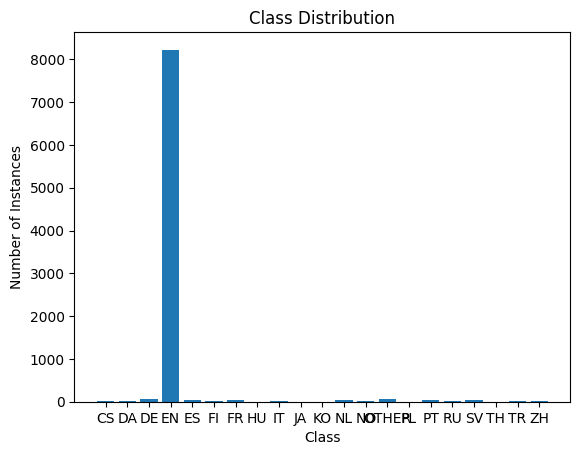

In [ ]:

import matplotlib.pyplot as plt

# class labels
labels = [t.split("_")[1] for t in target ]

# number of instances for each class
instances = np.unique(np.argmax(y, axis=1), return_counts=True)[1]

# create bar chart
plt.bar(labels, instances)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()

## Compute class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(np.argmax(y, axis=1)),
                                    y=np.argmax(y, axis=1))
list(class_weight)

[34.43650793650794,
 19.67800453514739,
 5.584298584298584,
 0.050235606034293126,
 8.98343685300207,
 29.517006802721088,
 11.806802721088435,
 206.61904761904762,
 41.32380952380952,
 82.64761904761905,
 137.74603174603175,
 12.15406162464986,
 21.74937343358396,
 7.249791144527987,
 82.64761904761905,
 10.87468671679198,
 19.67800453514739,
 13.33026113671275,
 206.61904761904762,
 59.034013605442176,
 25.827380952380953]

In [ ]:
len(nodes2.loc[nodes2['language_EN'] == 0])

452

## Edge index

In [ ]:
adj = nx.to_scipy_sparse_array(H).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64))
col = torch.from_numpy(adj.col.astype(np.int64))
edge_index = torch.stack([row, col], dim=0)

In [ ]:
print(X.shape)
print(y.shape)
print(edge_index.shape)

(8678, 128)
(8678, 21)
torch.Size([2, 20000])


## Create dataset

In [ ]:

from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, InMemoryDataset, Dataset
from torch_geometric.loader import DataLoader

class CustomDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(CustomDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        data.x = torch.from_numpy(X).type(torch.float32)
        data.y = torch.from_numpy(y).type(torch.float32)
        data.num_classes = len(y[0])

        integer_encoded = np.argmax(y, axis=1)

        X_train, X_test, y_train, y_test = train_test_split(pd.Series(X[:,0]),
                                                            pd.Series(y[:,0]),
                                                            test_size=0.30,
                                                            stratify=integer_encoded,
                                                            random_state=42)
        # create train and test masks for data
        train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

## Dataset info

In [ ]:
dataset = CustomDataset()
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(edge_index=[2, 20000], x=[8678, 128], y=[8678, 21], num_classes=21, train_mask=[8678], test_mask=[8678])
Number of nodes: 8678
Number of edges: 20000
Average node degree: 2.30
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
np.unique(np.argmax(data.y[data.test_mask], axis=1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [ ]:
nodes2.loc['155649']

0             -0.035722
1              0.253555
2              0.112876
3             -0.100739
4             -0.082656
                 ...   
language_RU    0.000000
language_SV    0.000000
language_TH    0.000000
language_TR    0.000000
language_ZH    0.000000
Name: 155649, Length: 161, dtype: float64

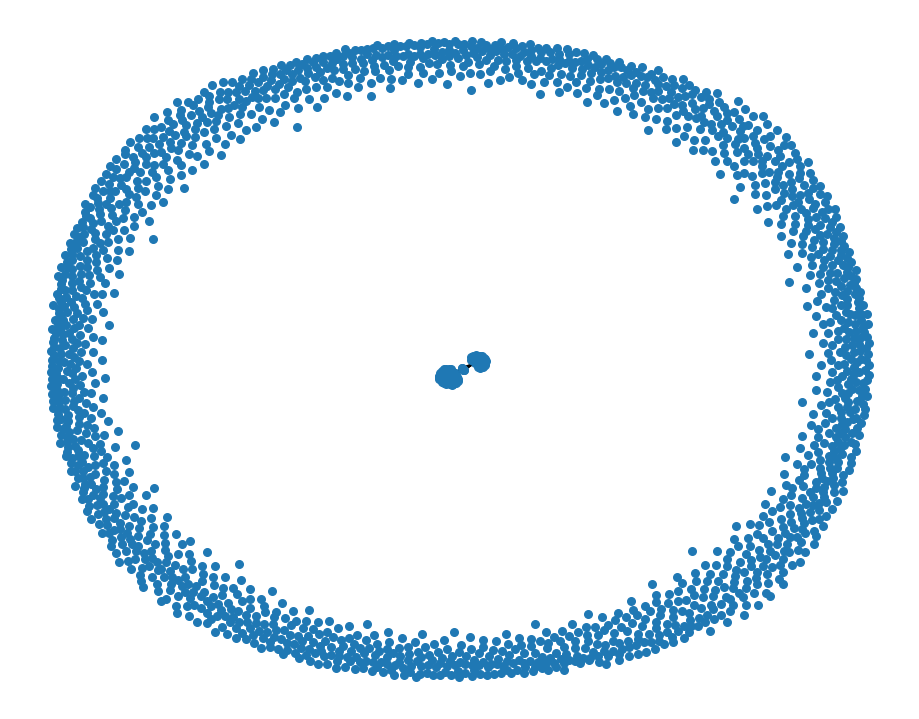

In [ ]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx

n_sample = 2000
y_enc = np.argmax(data.y.numpy(), axis=1)

sampled_nodes = np.random.choice(H.nodes, n_sample)
H_sub = H.subgraph(sampled_nodes)

# y_sub = y_enc[H_sub.nodes]

plt.figure(figsize=(9, 7))
nx.draw_spring(H_sub, node_size=30, arrows=False, )
plt.show()



In [ ]:
# import torch_geometric.transforms as T

# split = T.RandomNodeSplit(num_val=0.1,  num_test=0.2)
# data = split(data)

# Models

In [ ]:
from torchmetrics import AUROC, Accuracy
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out, _ = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc, auc = eval_node_classifier(model, graph, graph.train_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Acc: {acc:.3f}, AUC: {auc:.3f}')

    return model


def eval_node_classifier(model, data, mask):

    model.eval()
    preds, _ = model(data)
    preds = preds[data.test_mask]
    trues = data.y.argmax(dim=1)[data.test_mask]
    accuracy = Accuracy(task="multiclass", num_classes=dataset.num_classes).to(device)
    acc = accuracy(preds.argmax(dim=1),  trues)

    auroc = AUROC(task="multiclass", num_classes=dataset.num_classes).to(device)
    auc = auroc(preds,  trues)
    return acc, auc


Visualize function

In [ ]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import colormaps

cm = colormaps['tab20']
cm = [cm.colors[i] for i in range(len(cm.colors))] + [(0.0,0.0,0.0)]
print(cm)

def visualize(h, labels):
    z = PCA(n_components=2).fit_transform(h.cpu().detach().numpy())

    classes  =np.unique(labels)
    fig, ax = plt.subplots(figsize=(10,10))

    for c in classes:
      idx = np.where(labels==c)
      plt.scatter(z[idx, 0], z[idx, 1], label=f'{c}',s=70, c=cm[c])

    plt.legend()
    plt.show()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), (1.0, 0.4980392156862745, 0.054901960784313725), (1.0, 0.7333333333333333, 0.47058823529411764), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.596078431372549, 0.8745098039215686, 0.5411764705882353), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (1.0, 0.596078431372549, 0.5882352941176471), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.7725490196078432, 0.6901960784313725, 0.8352941176470589), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.7686274509803922, 0.611764705882353, 0.5803921568627451), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.9686274509803922, 0.7137254901960784, 0.8235294117647058), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7803921568627451, 0.7803921568627451, 0.7803921568627451), (0.7372549019607844, 0.7411764705882353, 0.1333

In [ ]:
def visualize_features(model, data, device, n):
  model.to(device)
  model.eval()

  data.to(device)

  _, features = model(data)
  y_enc = np.argmax(data.y.cpu().detach().numpy(), axis=1)
  visualize(features[:n], labels=y_enc[:n])

Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data.to(device)

Data(edge_index=[2, 20000], x=[8678, 128], y=[8678, 21], num_classes=21, train_mask=[8678], test_mask=[8678])

## MLP

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, 32)
        self.lin2 = Linear(32, dataset.num_classes)

    def forward(self, data):
        x = data.x
        features = F.relu(self.lin1(x))
        features = F.dropout(features, p=0.5, training=self.training)
        logits = self.lin2(features)
        out = F.softmax(logits, dim=1)
        return out, features

mlp = MLP().to(device)
print(mlp)

MLP(
  (lin1): Linear(in_features=128, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=21, bias=True)
)


### Evaluate before training


In [ ]:
test_acc, test_auc = eval_node_classifier(mlp, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.001, Test auc: 0.522


### Visualization of the node embeddings before training

<ipython-input-152-cc07ab43160d>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(z[idx, 0], z[idx, 1], label=f'{c}',s=70, c=cm[c])


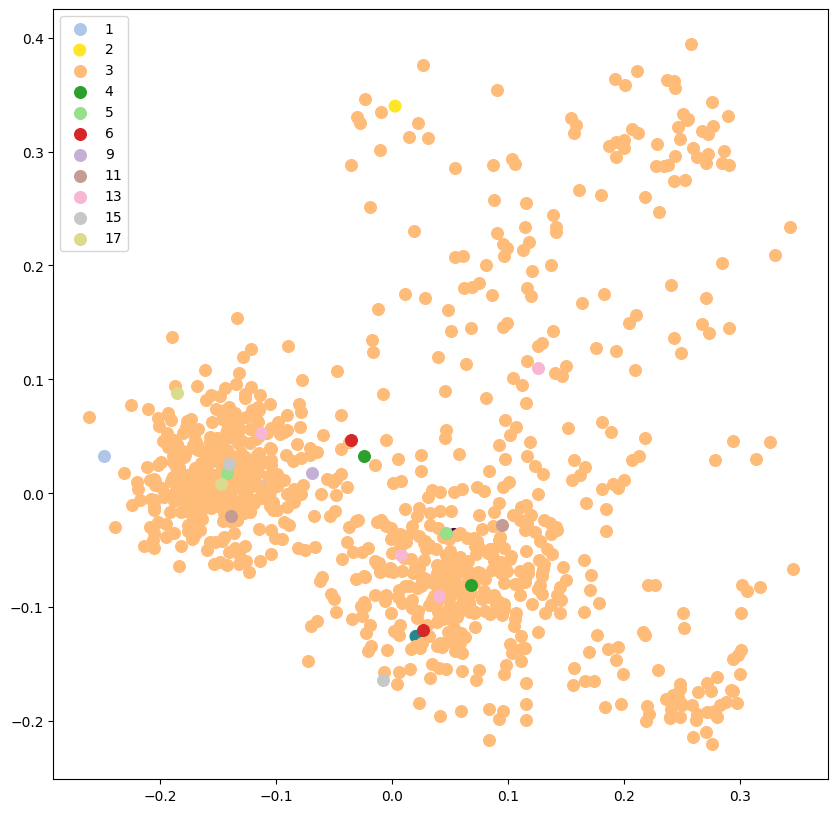

In [ ]:
visualize_features(mlp, data, device, 1000)

### Training

In [ ]:
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)

class_weights = torch.FloatTensor(class_weight).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

mlp = train_node_classifier(mlp, data, optimizer, criterion, n_epochs=100)


Epoch: 010, Train Loss: 2.952, Acc: 0.035, AUC: 0.488
Epoch: 020, Train Loss: 2.945, Acc: 0.003, AUC: 0.524
Epoch: 030, Train Loss: 2.936, Acc: 0.002, AUC: 0.512
Epoch: 040, Train Loss: 2.919, Acc: 0.002, AUC: 0.496
Epoch: 050, Train Loss: 2.909, Acc: 0.003, AUC: 0.506
Epoch: 060, Train Loss: 2.902, Acc: 0.002, AUC: 0.514
Epoch: 070, Train Loss: 2.872, Acc: 0.003, AUC: 0.516
Epoch: 080, Train Loss: 2.833, Acc: 0.002, AUC: 0.523
Epoch: 090, Train Loss: 2.873, Acc: 0.002, AUC: 0.532
Epoch: 100, Train Loss: 2.852, Acc: 0.002, AUC: 0.519


### Evaluate after training


In [ ]:
test_acc, test_auc = eval_node_classifier(mlp, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.002, Test auc: 0.519


### Visualization of the node embeddings after training

<ipython-input-152-cc07ab43160d>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(z[idx, 0], z[idx, 1], label=f'{c}',s=70, c=cm[c])


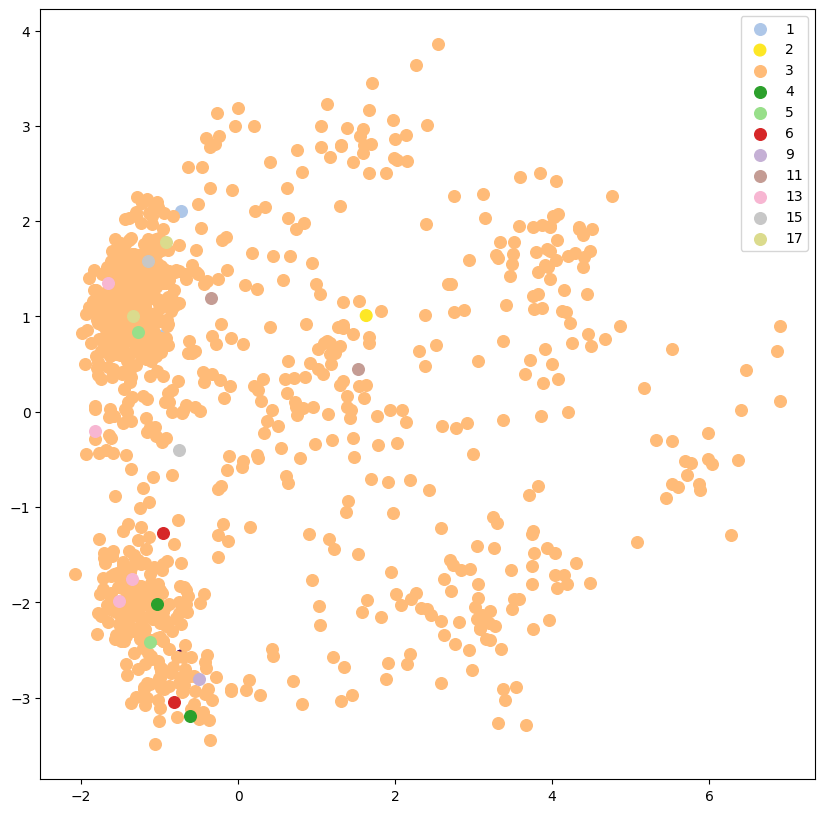

In [ ]:
visualize_features(mlp, data, device, 1000)

## GNN GCNConv

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, 16, add_self_loops=False, improved=True, normalize=True)
        self.conv2 = GCNConv(16, 16, add_self_loops=False, improved=True, normalize=True)
        self.classifier = Linear(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        features = F.relu(self.conv2(x, edge_index))
        features = F.dropout(features, p=0.2, training=self.training)

        out = self.classifier(features)

        return out, features

gcn = GCN().to(device)
print(gcn)

GCN(
  (conv1): GCNConv(128, 16)
  (conv2): GCNConv(16, 16)
  (classifier): Linear(in_features=16, out_features=21, bias=True)
)


### Evaluate before training

In [ ]:
test_acc, test_auc = eval_node_classifier(gcn, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.002, Test auc: 0.483


### Visualization of the node embeddings before training

<ipython-input-152-cc07ab43160d>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(z[idx, 0], z[idx, 1], label=f'{c}',s=70, c=cm[c])


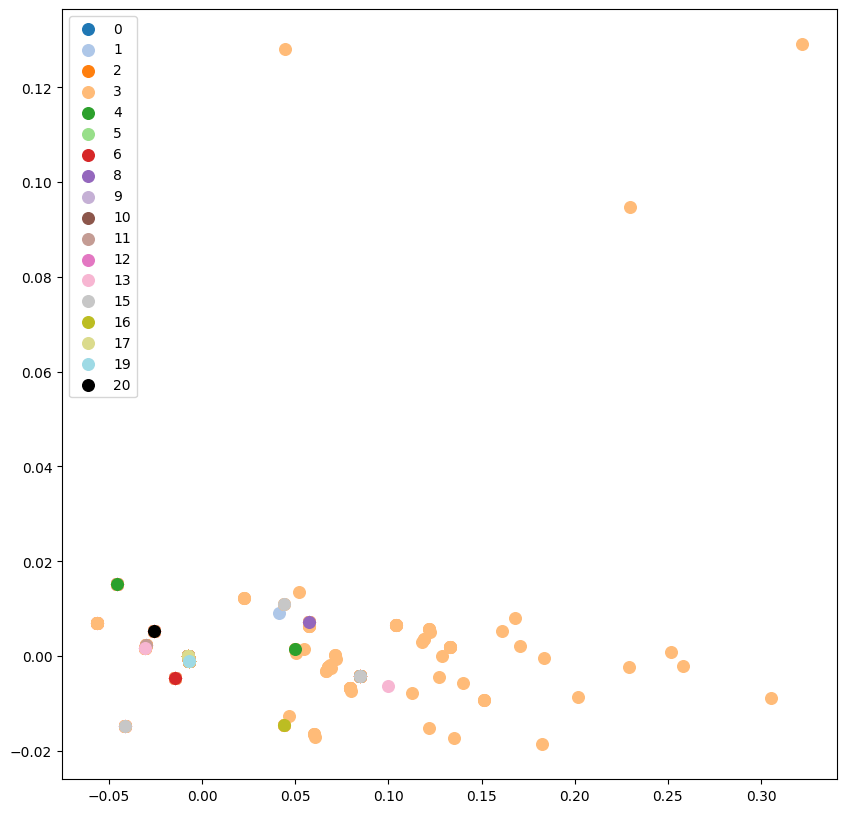

In [ ]:
visualize_features(gcn, data, device, 2000)

### Training

In [ ]:
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)

class_weights = torch.FloatTensor(class_weight).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

gcn = train_node_classifier(gcn, data, optimizer, criterion, n_epochs=100)


Epoch: 010, Train Loss: 2.948, Acc: 0.000, AUC: 0.448
Epoch: 020, Train Loss: 2.943, Acc: 0.000, AUC: 0.518
Epoch: 030, Train Loss: 2.940, Acc: 0.000, AUC: 0.497
Epoch: 040, Train Loss: 2.935, Acc: 0.000, AUC: 0.497
Epoch: 050, Train Loss: 2.951, Acc: 0.000, AUC: 0.485
Epoch: 060, Train Loss: 2.939, Acc: 0.000, AUC: 0.502
Epoch: 070, Train Loss: 2.945, Acc: 0.000, AUC: 0.497
Epoch: 080, Train Loss: 2.947, Acc: 0.000, AUC: 0.497
Epoch: 090, Train Loss: 2.943, Acc: 0.000, AUC: 0.497
Epoch: 100, Train Loss: 2.961, Acc: 0.000, AUC: 0.497


### Evaluate after training

In [ ]:
test_acc, test_auc = eval_node_classifier(gcn, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.000, Test auc: 0.497


### Visualization of the node embeddings after training

<ipython-input-152-cc07ab43160d>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(z[idx, 0], z[idx, 1], label=f'{c}',s=70, c=cm[c])


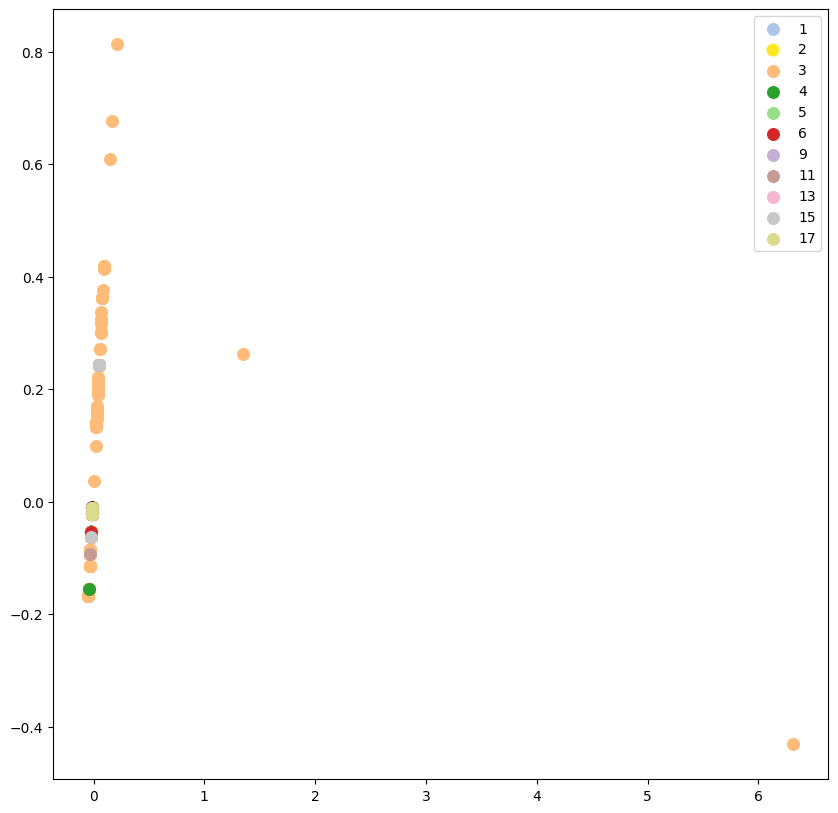

In [ ]:
visualize_features(gcn, data, device, 1000)

## GNN GCNConv

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, 32)
        self.conv2 = GCNConv(32, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        features = F.relu(self.conv2(x, edge_index))
        out = F.dropout(features, p=0.2, training=self.training)

        return out, out

gcn = GCN().to(device)
print(gcn)

GCN(
  (conv1): GCNConv(12, 32)
  (conv2): GCNConv(32, 21)
)


### Evaluate before training

In [ ]:
test_acc, test_auc = eval_node_classifier(gcn, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.007, Test auc: 0.511


### Visualization of the node embeddings before training

<ipython-input-29-cc07ab43160d>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(z[idx, 0], z[idx, 1], label=f'{c}',s=70, c=cm[c])


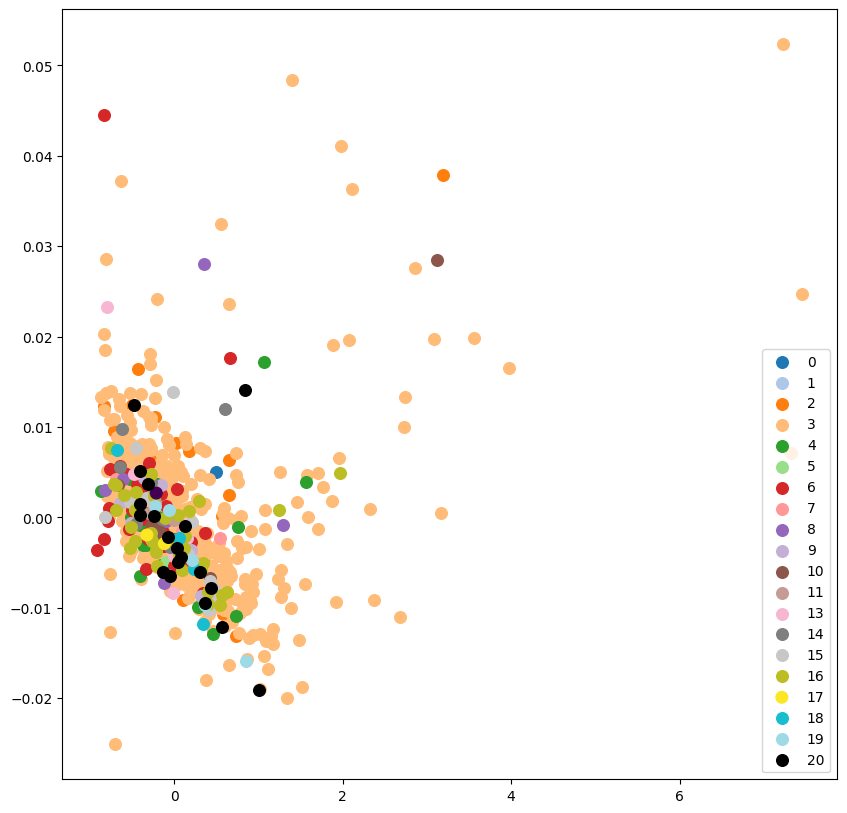

In [ ]:
visualize_features(gcn, data, device, 1000)

### Training

In [ ]:
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)

class_weights = torch.FloatTensor(class_weight).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

gcn = train_node_classifier(gcn, data, optimizer, criterion, n_epochs=100)


Epoch: 010, Train Loss: 3.051, Val Acc: 0.087, Val AUC: 0.512
Epoch: 020, Train Loss: 3.051, Val Acc: 0.017, Val AUC: 0.500
Epoch: 030, Train Loss: 3.051, Val Acc: 0.352, Val AUC: 0.501
Epoch: 040, Train Loss: 3.051, Val Acc: 0.114, Val AUC: 0.506
Epoch: 050, Train Loss: 3.051, Val Acc: 0.017, Val AUC: 0.503
Epoch: 060, Train Loss: 3.051, Val Acc: 0.030, Val AUC: 0.504
Epoch: 070, Train Loss: 3.051, Val Acc: 0.049, Val AUC: 0.508
Epoch: 080, Train Loss: 3.051, Val Acc: 0.020, Val AUC: 0.508
Epoch: 090, Train Loss: 3.051, Val Acc: 0.003, Val AUC: 0.505
Epoch: 100, Train Loss: 3.051, Val Acc: 0.004, Val AUC: 0.508


### Evaluate after training

In [ ]:
test_acc, test_auc = eval_node_classifier(gcn, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test auc: {test_auc:.3f}')

Test Acc: 0.004, Test auc: 0.508


### Visualization of the node embeddings after training

<ipython-input-29-cc07ab43160d>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(z[idx, 0], z[idx, 1], label=f'{c}',s=70, c=cm[c])


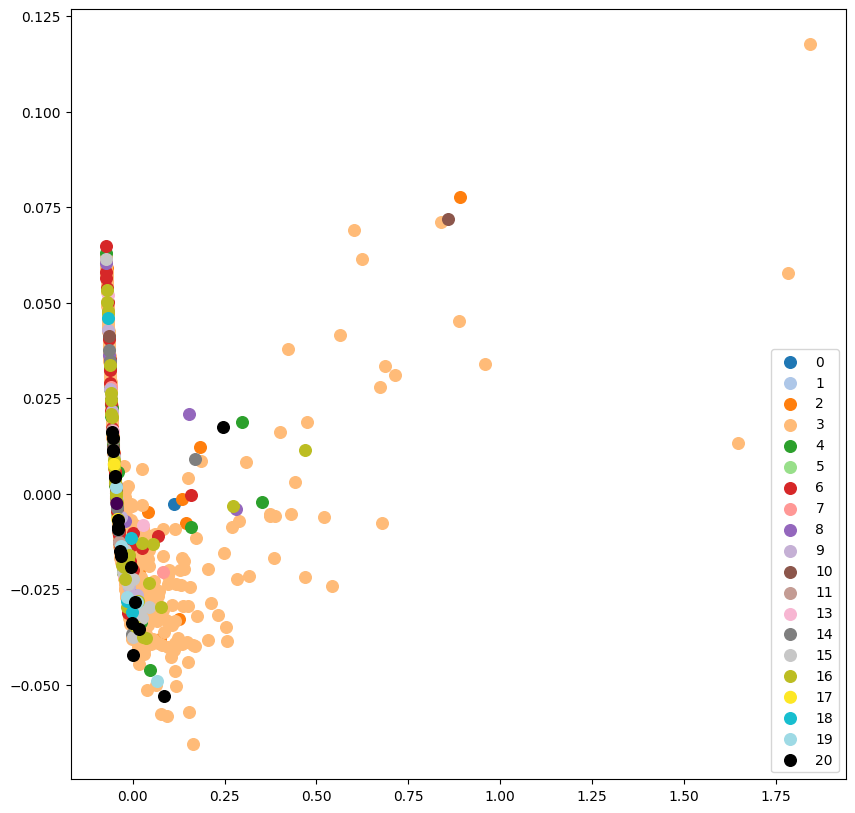

In [ ]:
visualize_features(gcn, data, device, 1000)